# Source Catalog: Loading, Plotting and Exploring Examples

In [1]:
import numpy as np
import os.path as op
import requests

from astropy.table import Table, unique

from hetdex_tools.source_catalog import plot_source_group
from hetdex_api.elixer_widget_cls import ElixerWidget
from hetdex_api.query_widget import QueryWidget
from hetdex_api.amp_widget import AmpWidget
from hetdex_api.config import HDRconfig

This catalog is a combination of sources from the continuum source catalog, the curated detection line catalog of the same version and the confirmed AGN detection IDs from Chenxu Liu's AGN search. A source_id is assigned to a group of detections that are first matched in 3D space through FOF clustering in RA/DEC/WAVE at a linking length of 6 arcsec and 6 AA in the spectral direction. FOF grouping of detections close on sky is done at a smaller linking length of 3AA. This can result in some background sources getting sweeped into a foreground object. Sources in repeat observation are NOT grouped together into one source_id. The column 'line_id' will identify a line species for a specific line emission detection if it is an observed wavelength match to the line given the determined redshift (z_hetdex) of a source. 

The column `'det_type'` can be `['line','cont','agn']`. The column "source_type" describes the source classifcation 'agn','lae', 'oii', 'star', 'lzg'(low-z galaxy without line emission), 'unsure' and 'z_hetdex' provides the best redshift which is a combination of Diagnose redshifts (g<22), Elixer redshifts (g>22) and AGN redshifts. Please read the first public source catalog paper for more info  https://iopscience.iop.org/article/10.3847/1538-4357/aca962.

Please report issues to Erin at erin_@_astro.

### Column Info can be found here:


https://op1srv.mpe.mpg.de/wikihetdex/index.php/Column_Info


## Open the catalog. We can use HDRconfig to identify the system path

In [2]:
# Enter the catalog version

version = '5.0.1'
hdrv = 'hdr{}'.format(version[0])
config = HDRconfig()
catfile = op.join(config.hdr_dir[hdrv], 'catalogs', 'source_catalog_' + version + '.fits')
source_table = Table.read(catfile)

print('Source catalog was found at {}'.format(catfile))

Source catalog was found at /scratch/projects/hetdex/hdr5/catalogs/source_catalog_5.0.1.fits


## Karl's LAE Cosmology Sample Cuts

In [5]:
sel_best = (source_table['flag_best']==1) * (source_table['flag_seldet'] == 1) * (source_table['flag_shot_cosmology']==1)
sel_lae =  (source_table['z_hetdex'] >= 1.87) * (source_table['z_hetdex']<=3.53)* (source_table['line_id']=='Lya')
sel_apcor = (source_table['apcor'] > 0.4)
sel_lya = np.abs(source_table['wave'] - (1215.67*(1+source_table['z_hetdex']))) <= 10

In [6]:
lae_sample = source_table[ sel_best & sel_lae & sel_apcor & sel_lya ]

In [7]:
len(lae_sample)

1642390

# Additional Confidence Cuts

Currently we find that CNN_Score_2DSpectra, sn_rres, p_conf (above S/N>5.5) appear to provide good cuts to improve the confidence of the sample. We suggest you play with the CNN_Score_2DSpectra and sn_rres thresholds. The higher the value the more confident, but the lower the numbers.

In [9]:
sel_cut1 = (lae_sample['sn_rres'] >= 4.5)
sel_cut2 = np.invert((lae_sample['p_conf'] < 0.5) * (lae_sample['sn'] >= 5.5))
sel_cut3 = lae_sample['CNN_Score_2D_Spectra'] >= 0.4
sel_cuts = sel_cut1 * sel_cut2 * sel_cut3

In [10]:
np.sum(sel_cuts)

813077

### NEW!!! We will continue to update the bad detection list on github. These can be removed from the catalog using this cell.

# set to true to update flags for all newly found bad detects since catalog release
update_baddets = True

if update_baddets:
    current_good_dets = np.array(source_table['detectid'][source_table['flag_baddet'] == 1])
    baddets = np.array( [int(det) for det in requests.get('https://raw.githubusercontent.com/HETDEX/hetdex_api/master/known_issues/hdr3/baddetects.list').text.split('\n')])
    
    update_these_dets = np.intersect1d( current_good_dets, baddets)

    for baddet in update_these_dets:
        #print('Updating flag for {}'.format(baddet))
        sel_det = source_table['detectid'] == baddet
        if source_table['flag_baddet'][sel_det] == 1:
            source_table['flag_baddet'][sel_det] = 0
            source_table['flag_best'][sel_det] = 0

You can sort the table using the `unique` function from `astropy.table` on the `source_id` key. For nearby galaxies, stars and AGN, many detectids can comprise the same source (ie. the same `source_id`). When you reduce the catalog using the `unique` function, only 1 detectid remains for the source. It is sorted such that the source with a wavelength matching the `z_guess` value is selected and the detectid is located close to the positional center of the source group. 

In [4]:
# selecting for S/N>=4.8line sources and all continuum + AGN sources
sel_sn = (source_table['sn'] >= 5.5) & (source_table['det_type'] == 'line')

sel_good = (source_table['flag_best'] == 1) * (source_table['flag_erin_cuts']==1)

sel_det = source_table['selected_det'] == True
sel_agn = source_table['source_type']=='agn'
sel_cont = source_table['det_type'] == 'cont'

sel_cat = (sel_sn | sel_cont | sel_agn) & sel_det & sel_good
uniq_table = unique(source_table[sel_cat], keys='source_id')

In [5]:
star = uniq_table['source_id'][uniq_table['source_type'] == 'star']
oii = uniq_table['source_id'][uniq_table['source_type'] == 'oii']
lae = uniq_table['source_id'][uniq_table['source_type'] == 'lae']
agn = uniq_table['source_id'][uniq_table['source_type'] == 'agn']
lzg = uniq_table['source_id'][uniq_table['source_type'] == 'lzg']

print('There are {} low-z gals, {} stars, {} OII emitters, {} AGN, and {} LAEs'. \
      format(np.size(lzg), np.size(star), np.size(oii), np.size(agn), np.size(lae)))

There are 27789 low-z gals, 118817 stars, 335737 OII emitters, 10148 AGN, and 204459 LAEs


## Here is an example of plotting a group

In [6]:
%matplotlib inline

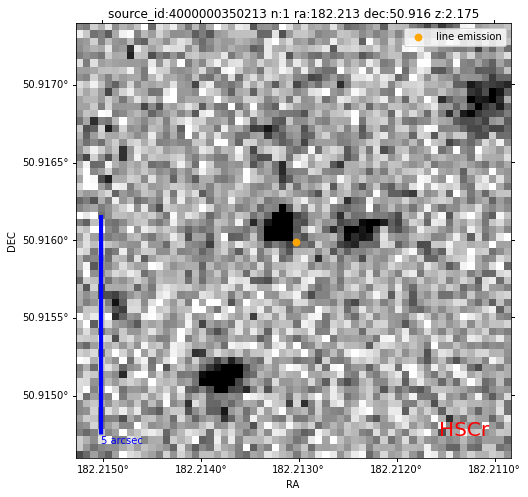

interactive(children=(Text(value='3002902731', description='DetectID:', placeholder='3002902731'), Output()), …

In [7]:
# the source_ids are sorted by member number ('n_member' in the catalog)
# This is how many detections are found in the source_id group

# Here's a query for high S/N LAEs
sel = (uniq_table['source_type'] == 'lae') & (uniq_table['sn'] > 6.5)
sid = uniq_table['source_id'][sel][9501]

# Index a star 
#sid = star[100]

# Index an OII galaxy
#sid = oii[0]

# Index an LAE
#sid = lae[0]

# Index the AGN list:
#sid = agn[0]

# This step grabs the source group so we can look at each source in Elixer
sel_group = (source_table['source_id'] == sid) 
group = source_table[sel_group]

#print(sid)
#print(group)

# this function overplots the source group over an image
# use label=True to see detectid's on image
# use save=True to save the image to you working directory
# the size of the line emission is scaled to the S/N of the line

plot_source_group(source_id = sid, source_table = source_table, label = False, save = False)
EW = ElixerWidget(detectlist = source_table['detectid'][sel_group])

## Follow a detection in the 2D image with AmpWidget 

This will map the detectid from the ElixerWidget above to the amp widget. The detection's highest weight fiber is marked with a red circle at the emission line wavelength.

In [8]:
AW = AmpWidget(detectid = EW.detid)

## Follow up with QueryWidget

You can extract fibers on demand around the detection via QueryWiget:

In [9]:
QW = QueryWidget(detectid = EW.detid)